# A/B тестирование
***

### Задача

Необходимо провести оценку результатов A/B-теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Краткое описание данных

- `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год, 
- `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года, 
- `final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года, 
- `final_ab_participants.csv` — таблица участников тестов.

# Оглавление<a class='anchor' id='TOC'></a>

* **[I. Подготовка к анализу](#1)**
    - [1) Импортируем библиотеки, прочитаем данные](#1_1)
* **[II. Анализ данных](#2)**
    - [1) Первичное ознакомление с данными](#2_1)
    - [2) Анализ соответствия данных техническому заданию](#2_2)
    - [3) Исследовательский анализ данных](#2_3)
    - [4) Воронка событий](#2_4)
* **[III. Анализ A/B-теста](#3)**
    - [1) Подготовимся к анализу](#3_1)
    - [2) Посчитаем метрики](#3_2)
    - [3) Проведем статистические тесты](#3_3)
* **[Выводы](#conclusions)**
<br></br>

# I. Подготовка к анализу<a class='anchor' id='1'></a>

## 1) Импортируем библиотеки, прочитаем данные<a class="anchor" id="1_1"></a>

In [1]:
import datetime
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

pio.renderers.default = 'iframe'

warnings.filterwarnings('ignore')

### - прочитаем данные

In [2]:
def reader(path):
    """Открываем файлы, присваиваем имена, добавляем в словарь, выводим отчет."""
    
    dates_columns = {'events': ['event_dt'], 
                     'marketing_events': ['start_dt', 'finish_dt'], 
                     'new_users': ['first_date'], 
                     'participants': []}
    
    df_dict = {}
    report = pd.DataFrame(columns=['variable', 'file_name'])
    files = os.listdir(path)

    for file in files:
        file_path = path + file
        if file in ['ab_project_marketing_events.csv', 'final_ab_new_users.csv', 
                    'final_ab_events.csv', 'final_ab_participants.csv', 'final_ab_marketing_events.csv']:
            if file == 'ab_project_marketing_events.csv':
                df_name = 'marketing_events'
            else:
                df_name = file.split('final_ab_')[1].split('.')[0]
            print(df_name)
            dates = dates_columns[df_name]
            df_dict[df_name] = pd.read_csv(file_path, parse_dates=dates)
            row_to_report = pd.DataFrame({'variable': [df_name],
                                          'file_name': [file]})
            report = pd.concat([report, row_to_report], ignore_index=True)
    
    print(f'Прочитано и добавлено в словарь {len(report)} файла.')
    return df_dict, report

In [3]:
datasets, report = reader('/datasets/')

participants
new_users
events
marketing_events
Прочитано и добавлено в словарь 4 файла.


In [4]:
report

,variable,file_name
0,participants,final_ab_participants.csv
1,new_users,final_ab_new_users.csv
2,events,final_ab_events.csv
3,marketing_events,ab_project_marketing_events.csv


[В оглавление](#TOC)

# II. Анализ данных<a class='anchor' id='2'></a>

## 1) Первичное ознакомление с данными<a class="anchor" id="2_1"></a>

### - инициализируем класс для анализа

In [5]:
class BasicInfo:
    """Выводим базовую информацию о датасете."""

    def __init__(self):
        self.data = None

    def get_info(self):
        """Получаем базовую информацию о таблице."""

        length = len(self.data)
        # Получаем типы данных и считаем пропуски
        types = pd.DataFrame(self.data.dtypes)
        nulls = pd.DataFrame(self.data.count())

        # Объединяем типы и пропуски, переименовываем колонки
        info = pd.concat([types, nulls], axis=1).reset_index()
        info.columns = ['Column', 'Dtype', 'Non-Null Count']

        # Считаем процент пропусков
        info['% of nulls'] = (100 -
                              round(info['Non-Null Count'] / length * 100, 2))

        return info

    def get_describe(self, numeric=False):
        """Считаем описательную статистику."""
        describes = None
        # Если нет числовых значений
        if not numeric:
            describes = self.data.describe(exclude=[np.number]).fillna('---').T
            top_percent = round((describes['freq'] * 100 /
                                 describes['count']).astype(float), 2)
            describes.insert(4, '% of tops freq', top_percent)
            return describes.sort_values(by='freq')
        return describes

    def basic_info_printer(self, data):
        """Выводим первые и пооследние пять строк, 
        базовую информацию, статистику."""
        
        self.data = data

        # Получаем базовую информацию
        info = self.get_info()

        # Получаем базовую статистику
        describes = self.get_describe()

        display('Пять первых и последних строк', self.data.head(), self.data.tail(),
                'Общая информация о датасете', info,
                'Описательная статистика', describes)


In [6]:
def simple_grouper(data, grouper, agg_dict={'user_id': 'count'}):
    """Группируем данные, считаем процентное отношение."""
    data = data.groupby(grouper).agg(agg_dict).reset_index()
    if 'user_id' in agg_dict.keys():
        data['percent'] = round(data['user_id'] * 100 / data['user_id'].sum(), 2)
        data = data.sort_values(by='user_id', ascending=False)
    return data


In [7]:
info_printer = BasicInfo()

[В оглавление](#TOC)

### - проверим полные дубликаты в данных

In [8]:
duplicated_sum = 0
for key, dataset in datasets.items():
    duplicated_sum += (dataset.duplicated() == True).sum()
print(duplicated_sum)

0


&#9889; **Выводы**

Полных дубликатов в данных нет.

[В оглавление](#TOC)

### - выведем первые пять первых и последних строк таблицы с участниками, общую информацию, статиcтику

In [9]:
info_printer.basic_info_printer(datasets['participants'])

'Пять первых и последних строк'

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


,user_id,group,ab_test
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test
18267,79F9ABFB029CF724,B,interface_eu_test


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,user_id,object,18268,0.0
1,group,object,18268,0.0
2,ab_test,object,18268,0.0


'Описательная статистика'

,count,unique,top,freq,% of tops freq
user_id,18268,16666,455184E9E3948A22,2,0.01
group,18268,2,A,9655,52.85
ab_test,18268,2,interface_eu_test,11567,63.32


&#9889; **Выводы**

1. В датасете с информацией об участниках тестов нет пропусков, нет проблем с типами данных.
2. Представлены данные об участниках двух различных тестов - recommender_system_test, interface_eu_test.
3. Полных дубликатов нет, однако из 18 268 пользователей уникальных - 16 666, то есть 1602 участника участвовали в обоих тестах. 
4. По данному датасету потребуется фильтровать участников из данных для статистических тестов, как следствие, предварительно потребутся отобрать только тех пользователей и события, которые относятся к interface_eu_test.

[В оглавление](#TOC)

### - выведем первые пять первых и последних строк таблицы с новыми пользователями, общую информацию, статиcтику

In [10]:
info_printer.basic_info_printer(datasets['new_users'])

'Пять первых и последних строк'

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


,user_id,first_date,region,device
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone
61732,8F04273BB2860229,2020-12-20,EU,Android


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,user_id,object,61733,0.0
1,first_date,datetime64[ns],61733,0.0
2,region,object,61733,0.0
3,device,object,61733,0.0


'Описательная статистика'

,count,unique,top,freq,% of tops freq,first,last
user_id,61733,61733,AD51737C9FA396F1,1,0.00,---,---
first_date,61733,17,2020-12-21 00:00:00,6290,10.19,2020-12-07 00:00:00,2020-12-23 00:00:00
device,61733,4,Android,27520,44.58,---,---
region,61733,4,EU,46270,74.95,---,---


&#9889; **Выводы**

1. В датасете с информацией о новых пользователях нет пропусков, нет проблем с типами данных.
2. Всего представлены данные о 61 733 пользователях из четырех регионов, четырех видах устройства.
3. В данных наблюдения за 17 дней, больше всего наблюдений (6290 из 61773, 10.19%) о 21.12.2020 года.
4. Из 61 733 наблюдений - в 27 520 (44.58%) зафикисировано устройство на андройде, 46 270 (74.95%) регион - EU.

[В оглавление](#TOC)

### - выведем первые пять первых и последних строк таблицы с событиями, общую информацию, статиcтику

In [11]:
info_printer.basic_info_printer(datasets['events'])

'Пять первых и последних строк'

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


,user_id,event_dt,event_name,details
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
440316,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,user_id,object,440317,0.00
1,event_dt,datetime64[ns],440317,0.00
2,event_name,object,440317,0.00
3,details,float64,62740,85.75


'Описательная статистика'

,count,unique,top,freq,% of tops freq,first,last
event_dt,440317,267268,2020-12-14 18:54:55,10,0.00,2020-12-07 00:00:33,2020-12-30 23:36:33
user_id,440317,58703,A3917F81482141F2,36,0.01,---,---
event_name,440317,4,login,189552,43.05,---,---


&#9889; **Выводы**

1. В датасете с информацией о событиях нет проблем с типами данных, есть пропуски в стобце details — дополнительные данные есть только о 62 740 наблюдениях из 440 317: 85.75% пропусков. Пропуски носят смысловой характер - о некоторых событиях нет и не может быть дополнительных данных.
2. Из 440 317 наблюдений о событиях - 189 552 наблюдения (43.05%) это авторизация.
3. Период наблюдений в данных не соответсвует периоду проведения теста - вместо 14 дней представлены данные за 10 дней.

[В оглавление](#TOC)

### - выведем первые пять первых и последних строк таблицы с маркетинговыми акциями, общую информацию, статиcтику

In [12]:
info_printer.basic_info_printer(datasets['marketing_events'])

'Пять первых и последних строк'

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


,name,regions,start_dt,finish_dt
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


'Общая информация о датасете'

,Column,Dtype,Non-Null Count,% of nulls
0,name,object,14,0.0
1,regions,object,14,0.0
2,start_dt,datetime64[ns],14,0.0
3,finish_dt,datetime64[ns],14,0.0


'Описательная статистика'

,count,unique,top,freq,% of tops freq,first,last
name,14,14,Single's Day Gift Promo,1,7.14,---,---
start_dt,14,14,2020-07-04 00:00:00,1,7.14,2020-01-25 00:00:00,2020-12-30 00:00:00
finish_dt,14,14,2020-03-10 00:00:00,1,7.14,2020-02-07 00:00:00,2021-01-07 00:00:00
regions,14,6,APAC,4,28.57,---,---


&#9889; **Выводы**

1. В датасете с информацией о марктинговых акциях нет проблем с типами данных, не пропусков.
2. Всего представлены данные о 14 маркетинговых акциях за период от 25 января 2020 года до 07 января 2021 года.

[В оглавление](#TOC)

### - проверим последовательно ли идут события

Убедимся в том, что события представлены последовательно во времени:

In [13]:
datasets['events']['event_dt'].is_monotonic

False

&#9889; **Выводы**

В таблице события представлены непоследовательно, потребуется отсорировать данные по столбцу со временем - в том числе, с точки зрения конверсии, для правильной последовательности событий.

[В оглавление](#TOC)

## 2) Анализ соответствия данных техническому заданию<a class="anchor" id="2_2"></a>

Зададим функцию для проверки пересечений пользователей:

In [14]:
def get_intersections(data, query_mask={}):
    """Проверяем, что пользователи из двух групп изолированы."""
    first_query = 'group == "A"'
    second_query = 'group == "B"'
    
    if query_mask:
        first_query = query_mask['first_query']
        second_query = query_mask['second_query']
    
    # отбираем группы из данных с заказами
    group_a = data.query(first_query)
    group_b = data.query(second_query)

    # получаем пользователей, попавших в обе группы
    group_intersections = list(np.intersect1d(group_a['user_id'],
                                              group_b['user_id']))

    return group_intersections

### - проверим наличие пересечений пользователей в конкурирующих тестах

Данные об участниках теста содержаться в датасете participants. После первичного ознакомления с данными было установлено, что 1602 пользователя участвовали в двух конкурирующих тестах - рекомендательной системы и, с некоторой осторожостью, интерфейса. Проверим еще раз пересечения и, на всякий случай, сохраним список пользователей, принявших участие в обоих тестах:

In [15]:
query_mask = {'first_query': 'ab_test == "recommender_system_test"',
              'second_query': 'ab_test == "interface_eu_test"'}

In [16]:
tests_intersections = get_intersections(datasets['participants'], query_mask)
len(tests_intersections)

1602

&#9889; **Выводы**

С учетом того, что у нас нет данных о времени проведения теста интерфейса - мы не можем сделать с разумной степенью достоверности выводов из факта пересечения, но это повод уточнить сведения о втором тесте у поставщика данных. В любом случае, 1602 пользователя участовало в обоих тестах, проверим не входят ли какие-то из них в группа А конкурирующего теста - в этом случае мы сможем сохранить их в выборке.

[В оглавление](#TOC)

### - проверим, входят ли пользователи из выявленных 1602 пользователей в группу А конкурирующего теста

С целью сохранения данных, ели пользователи входят только в группу А конкурирующего теста - то есть, тех пользователей, которые не видели изменений - мы можем оставить их. Сделаем копию датасета с участниками:

In [17]:
test_participants = datasets['participants'].copy()
test_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


Сделаем выборку по участникам из группы А и тестом "interface_eu_test":

In [18]:
group_a_interface_test = test_participants.query('group == "A" and ab_test == "interface_eu_test"')
valid_user_intersections = list(np.intersect1d(group_a_interface_test['user_id'], tests_intersections))
len(valid_user_intersections)

819

Из 1602 пользователей, принявших участие в обоих теста, 819 пользователей попали в группу А конкурирующего теста - сохраним их, остальных исключим. Для этого обновим маску с tests_intersections, исключив 819 наблюдений:

In [19]:
tests_intersections = np.array(tests_intersections) # векторизируем изначальный список с пересечениями
valid_user_intersections = np.array(valid_user_intersections) # векторизируем список с допустимыми пересечениями
tests_intersections = np.setdiff1d(tests_intersections, valid_user_intersections) # исключим допустимые пересечения из недопустимых
len(tests_intersections)

783

&#9889; **Выводы**

После проверки 1602 пользователя участовавших в обоих тестах, выяснили, что 819 из них входят в группу А конкурирующего теста - решили сохранить их в выборке, исключили из числа недопустимых пересечений, которых осталось 783 (1602 - 819).

### - проверим наличие пересечений в группах

Отберем только тех участников, которые участововали в тесте рекомендательной системы:

In [20]:
test_participants = datasets['participants'].query('ab_test == "recommender_system_test"')
test_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


Исключим из выборки пользователей, участвовавших в обоих тестах и которые попали в группу В конкурирующего теста:

In [21]:
test_participants = test_participants.query('user_id not in @tests_intersections')
test_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


Получили выборку из 5918 пользователей. Проверим пересечения в полученной выборке:

In [22]:
len(get_intersections(test_participants))

0

&#9889; **Выводы**

Пользователи группы А и В изолированы друг от друга.

[В оглавление](#TOC)

### - убедимся, что все участники - новые пользователи

В соответствии с техническим заданием в тесте должны участвовать новые пользователи из региона EU, зарегистрированные в период от 07.12.2020 года до 21.12.2020 года. 

In [23]:
check_is_newby = datasets['new_users'].query('user_id in @test_participants.user_id')
check_is_newby

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
20,DD4352CDCF8C3D57,2020-12-07,EU,Android
23,831887FE7F2D6CBA,2020-12-07,EU,Android
39,4CB179C7F847320B,2020-12-07,EU,iPhone
40,29C92313A98B1176,2020-12-07,APAC,Android
...,...,...,...,...
61681,3CA972F86411CF13,2020-12-20,EU,PC
61693,0F7D49FC184EDCDE,2020-12-20,EU,PC
61709,574ACBC674BC385D,2020-12-20,EU,Mac
61710,0416B34D35C8C8B8,2020-12-20,EU,Android


&#9889; **Выводы**

Все участники - 5918 - представлены в таблице с новыми пользователями. 

[В оглавление](#TOC)

### - убедимся, что все участники из Европы

In [24]:
check_is_newby.describe().T

,count,unique,top,freq,first,last
user_id,5918,5918,21EA4E846C63EEA2,1,NaT,NaT
first_date,5918,15,2020-12-21 00:00:00,639,2020-12-07,2020-12-21
region,5918,4,EU,5568,NaT,NaT
device,5918,4,Android,2656,NaT,NaT


In [25]:
check_is_newby.region.unique()

array(['EU', 'APAC', 'CIS', 'N.America'], dtype=object)

В тестовые группы попали 350 участников (5 %) из других регионов - Азиатско-Тихоокеанский регион, СНГ и Северной Америки. Исключим участников из других регионов:

In [26]:
only_eu_participants = check_is_newby.query('region == "EU"').copy()
len(only_eu_participants)

5568

Учтем это в выборке участников:

In [27]:
test_participants = test_participants.query('user_id in @only_eu_participants.user_id')
test_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6346,7C5C12FA1B5AB710,A,recommender_system_test
6347,91C3969B8A72B908,B,recommender_system_test
6348,E26F13A65CEAC6EA,A,recommender_system_test
6349,95401934D6D6D4FC,B,recommender_system_test


&#9889; **Выводы**

1. Данные не соответсвуют требованиям технического задания: в тестовые группы попали пользователи из неевропейских регионов: 350 участников (5 %) из Азиатско-Тихоокеанского региона, СНГ и Северной Америки.
2. Все участники - новые пользователи, с периодом регистрации от 7 до 21 декабря 2020 года (было установлено при первичном ознакомлении с данными).
3. Исключили участников из других регионов, получили датасет с 5568 наблюдениями.


[В оглавление](#TOC)

### - проверим сколько событий совершают пользователи за каждый день из 14

Расчитаем сколько дней проходит у пользователя между первым и последним действием:

In [28]:
events = datasets['events'].copy()

In [29]:
# вычислим первое событие 
users_events = (events
                .sort_values(by=['user_id', 'event_dt'])
                .groupby('user_id').agg({'event_dt': 'first',
                                         'event_name': 'first'})
                .rename(columns={'event_dt': 'first_ts',
                                 'event_name': 'first_event'})
                .reset_index())

# вычислим последнее событие 
last_event = (events.groupby(['user_id', 'event_dt'])
              .last()
              .reset_index()
              .drop_duplicates(subset=['user_id'], keep='last')
              [['user_id', 'event_name', 'event_dt']])
last_event.columns = ['user_id', 'last_event', 'last_ts']

# объединим таблицы, посчитаем период в днях
users_events = users_events.merge(last_event)
users_events['delta_in_days'] = round((users_events['last_ts'] - users_events['first_ts']).dt.total_seconds() / 3600 / 24, 2)
users_events

,user_id,first_ts,first_event,last_event,last_ts,delta_in_days
0,0001710F4DDB1D1B,2020-12-14 20:20:40,login,product_cart,2020-12-15 17:34:25,0.88
1,000199F1887AE5E6,2020-12-14 09:56:09,purchase,product_page,2020-12-21 02:11:24,6.68
2,0002499E372175C7,2020-12-22 03:49:52,purchase,login,2020-12-26 04:53:03,4.04
3,0002CE61FF2C4011,2020-12-07 04:37:36,login,product_page,2020-12-15 12:47:05,8.34
4,000456437D0EFFE1,2020-12-15 11:25:03,login,product_page,2020-12-26 21:15:16,11.41
...,...,...,...,...,...,...
58698,FFF7A7BAF44FE9B4,2020-12-19 11:10:03,login,login,2020-12-22 11:24:18,3.01
58699,FFF8FDBE2FE99C91,2020-12-20 04:53:50,purchase,login,2020-12-23 02:40:19,2.91
58700,FFF91B6C5431F375,2020-12-14 22:12:04,product_cart,product_cart,2020-12-25 07:12:52,10.38
58701,FFFAB034A09DCC28,2020-12-18 12:00:53,login,product_page,2020-12-21 01:46:45,2.57


Проверим общую статистику:

In [30]:
users_events.describe(percentiles=[.25, .5, .75, .95, .99]).T

,count,mean,std,min,25%,50%,75%,95%,99%,max
delta_in_days,58703.0,6.903668,5.156794,0.0,2.75,6.05,10.13,16.839,20.53,23.83


В среднем у пользователя от первого до последнего действия проходит около 7 дней, почти все пользователи уложились в 20 дней (99-ый перцентиль) при том, что 95% всех пользователей уложилось в 16 дней. Посчитаем статистику только для тех пользователей, у которых зафикисировано хотя бы одно из целевых действий - 'product_page', 'product_cart', 'purchase'.

In [31]:
target_events = ['product_page', 'product_cart', 'purchase']
user_target_events = users_events.query('first_event in @target_events or last_event in @target_events')
user_target_events.describe(percentiles=[.25, .5, .75, .95, .99]).T

,count,mean,std,min,25%,50%,75%,95%,99%,max
delta_in_days,43808.0,6.79005,5.169814,0.0,2.6075,5.94,10.0,16.78,20.4793,23.83


Сопоставимая статистика. Учтем группы пользователей:

In [32]:
events_of_test_participants = user_target_events.merge(test_participants)
group_a = events_of_test_participants.query('group == "A"')
group_b = events_of_test_participants.query('group == "B"')

Статистика групп А и В:

In [33]:
group_a.describe(percentiles=[.25, .5, .75, .95, .99]).T

,count,mean,std,min,25%,50%,75%,95%,99%,max
delta_in_days,1633.0,6.240018,4.586752,0.0,2.41,5.83,9.05,14.702,19.0364,22.16


In [34]:
group_b.describe(percentiles=[.25, .5, .75, .95, .99]).T

,count,mean,std,min,25%,50%,75%,95%,99%,max
delta_in_days,530.0,6.197528,5.893677,0.0,1.08,4.615,9.52,18.669,21.4209,22.88


И снова близкие значения. Визуализируем распределение:

In [35]:
def overlaid_histogram(data1, data2, labels=None, n_bins=0):
    """Строим соотносимые гистограммы для двух выборок"""  
    
    # если не переданы подписи
    if not labels:
        labels = {'data1_name': '',
                  'data2_name': '',
                  'xlabel': '', 
                  'ylabel': '',
                  'title': ''}
            
    # Устанавливаем границы для корзин так чтобы оба 
    # распределения на графике были соотносимы
    max_nbins = 10
    data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins


    if n_bins == 0:
        bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)
    else: 
        bins = n_bins

    # рисуем графики
    sns.set_style('whitegrid')
    
    plt.figure(figsize=(10, 8))

    plt.hist(data1, bins=bins, color='red',
            alpha=0.65, label=labels['data1_name'])
    plt.hist(data2, bins=bins, color='royalblue',
            alpha=0.65, label=labels['data2_name'])
    
    # добавляем средние  
    plt.axvline(data1.mean(), linestyle='--',
               color='lime', label=f'Среднее "{labels["data1_name"]}"')

    plt.axvline(data2.mean(), linestyle='--',
               color='coral', label=f'Среднее "{labels["data2_name"]}"')
    
    # спрячем сетку
    plt.grid(False)
    
    # спрячем лишние границы
    sns.despine(left=True, bottom=True)

    # подписываем график и оси 
    plt.xlabel(labels['xlabel'], labelpad=30)
    plt.ylabel(labels['ylabel'])
    plt.title(labels['title'], loc='left', pad=30,
              fontsize=12, fontweight='bold')
    plt.legend(loc=0)
    plt.tight_layout()


Зададим подписи для графика:

In [36]:
labels = {'data1_name': 'Пользователи группы А',
          'data2_name': 'Пользователи группы В',
          'xlabel': 'Дни между первым и последним действием', 
          'ylabel': 'Количество пользователей',
          'title': 'Распределение дней между первым и последним действием пользователей (по группам)'}

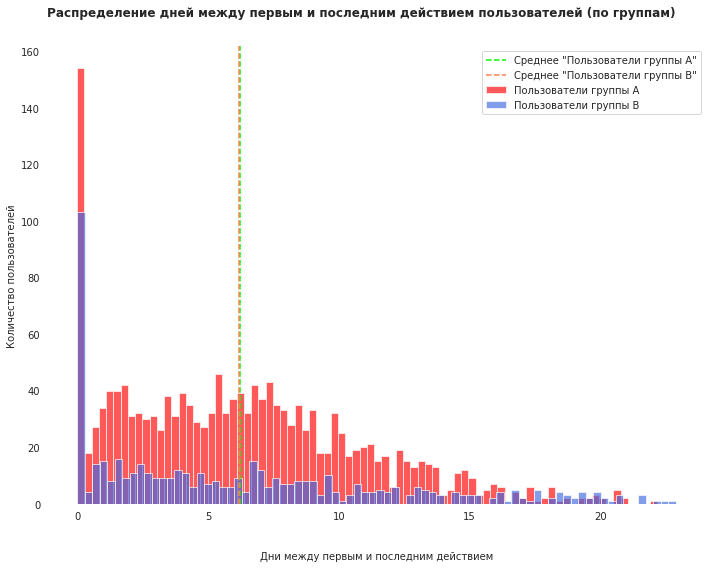

In [37]:
overlaid_histogram(group_a['delta_in_days'],
                   group_b['delta_in_days'],
                   labels, n_bins=80)

&#9889; **Выводы**

В среднем у пользователя от первого до последнего действия проходит около 7 дней, почти все пользователи уложились в 20 дней (99-ый перцентиль) при том, что 95% всех пользователей уложилось в 16 дней. В разрезе по группам, с учетом целевых действий существенного различия в статистике нет. Визуально заметно, что пользователей, которым необходимо более двух недель - не очень много.

### - посчитаем процент пользователей, которым требуется более 14 дней

В соответствии с техническим заданием дата остановки теста 04.01.2021 года, улучшение каждой метрики должно быть зафиксировано за 14 дней. Как было установлено при ознакомлении с данными в датасете с событиями наблюдения только до 30.12.2020 года. Посчитаем число пользователей, которые не уложились в 14 дней:

In [38]:
more_than_two_weeks = events_of_test_participants.query('delta_in_days > 14')
len(more_than_two_weeks)

168

Всего 168 пользователей:

In [39]:
len(more_than_two_weeks) / len(events_of_test_participants)

0.07766990291262135

Примерно 8% от числа участников. Исключим их:

In [40]:
test_participants = test_participants.query('user_id not in @more_than_two_weeks').copy()
test_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6346,7C5C12FA1B5AB710,A,recommender_system_test
6347,91C3969B8A72B908,B,recommender_system_test
6348,E26F13A65CEAC6EA,A,recommender_system_test
6349,95401934D6D6D4FC,B,recommender_system_test


&#9889; **Выводы**

В результате получили 5568 наблюдений.

[В оглавление](#TOC)

### - убедимся, что размер выборки составляет 15% от новых пользвателей из Европы 

Сначала посчитаем процент финальной сокращенной выборки:

In [41]:
round(len(test_participants) / len(datasets['new_users'].query('region == "EU"')) * 100, 2)

12.03

Всего 12.03% от новых пользователей из Европы: по техническому заданияю предполагается 15% от размера по техническому заданию.

&#9889; **Выводы**

Сокращенная выборка, с поправкой на пересечене, из 5568 пользователей составляет 12.03% от новых пользователей из Европы - вдвое меньше предполагаемого размера.

[В оглавление](#TOC)

### - проверим, что время проведения теста не совпадает с маркетинговыми и другими активностями

Период проведений теста - 7 декабря 2020 года - 4 января 2021 года. Данные о маркетиноговых событиях представлены в таблице marketing_events:

In [42]:
marketing_events = datasets['marketing_events'].copy()
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Отберем события в Европе, которые пересекаются с временем проведения теста:

In [43]:
def marketing_intersections_picker(row):
    """Отбираем маркетинговые события, совпавшие с тестом."""
    regions = row['regions'].split(',')
    start_date = datetime.datetime(2020, 12, 7)
    end_date = datetime.datetime(2021, 1, 4)
    if 'EU' in regions:
        if row['finish_dt'] > start_date and row['start_dt'] < end_date:
            return True
    return False

In [44]:
marketing_events['intersected'] = marketing_events.apply(marketing_intersections_picker, axis=1)
marketing_events.query('intersected == True')

,name,regions,start_dt,finish_dt,intersected
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True


&#9889; **Выводы**

1. Рождственское и Новогоднее промо частично совпадает с проведением теста - в период от 25.12.2020 до 01.03.2021 года.
2. Учитывая, что маркетинговые акции оказывают самостоятельное влияние на поведение пользователей - необходимо исключить из тестовой группы пользователей, у которых с момента регистрации не прошло 14 дней к 25.12.2020 году.

[В оглавление](#TOC)

### - проверим активность пользователей во времени

In [45]:
group_a['date'] = group_a.last_ts.dt.date
group_b['date'] = group_b.last_ts.dt.date

In [46]:
count_by_date_a = group_a.groupby('date').agg({'last_event': 'count'}).reset_index()
count_by_date_b = group_b.groupby('date').agg({'last_event': 'count'}).reset_index()

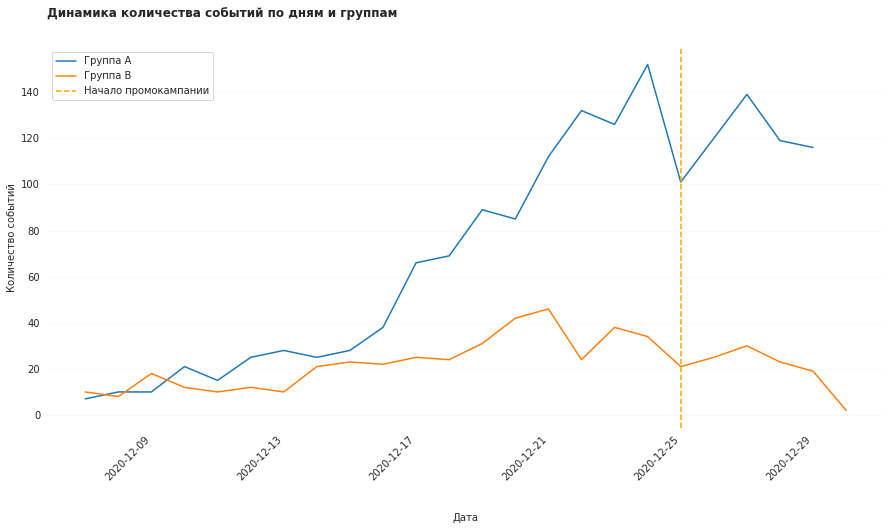

In [47]:
plt.figure(figsize=(15, 7))

plt.plot(count_by_date_a['date'], count_by_date_a['last_event'], label='Группа А')
plt.plot(count_by_date_b['date'], count_by_date_b['last_event'], label='Группа B')

# спрячем сетку
plt.grid(False)

# повернем засечки, подпишем оси
plt.xticks(rotation=45, ha="right")

# добавим легкие горизонтальные линии
plt.grid(axis='y', alpha=0.15)
plt.grid(axis='x', alpha=0)

# нанесем на график линию 
plt.axvline(datetime.datetime(2020, 12, 25), linestyle='--', 
            color='orange', label='Начало промокампании')

# спрячем лишние границы
sns.despine(left=True, bottom=True)

# подпишем график, выведем легенду,
plt.xlabel('Дата', labelpad=30)
plt.ylabel('Количество событий')
plt.title('Динамика количества событий по дням и группам', loc='left', pad=30,
          fontsize=12, fontweight='bold')
plt.legend(loc=0)
plt.show();

&#9889; **Выводы**

В целом схожая динамика, с поправкой на количество пользователей в группах: группа А многочисленнее. После 25 декабря в обоих группах наблюдается рост активности, который, впрочем идет на спад к 30 декабря. Полгаю, можно исходить из того, что промо примерно одинаково влияло на обе группы, так что проигнорируем пересечение с Christmas&New Year Promo.

[В оглавление](#TOC)

### - проверим итоговое число пользователей

Сделаем специальную копию таблицы с событиями, отфильтруем их по пользователям, обогатим информацией о группах.

In [48]:
len(test_participants)

5568

In [49]:
events = datasets['events'].copy()
events = events.query('user_id in @test_participants.user_id')
events = events.merge(test_participants, on='user_id')
events['dt'] = events['event_dt'].dt.date
events.head()


,user_id,event_dt,event_name,details,group,ab_test,dt
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07
1,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,A,recommender_system_test,2020-12-09
2,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,NaN,A,recommender_system_test,2020-12-07
3,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,NaN,A,recommender_system_test,2020-12-08
4,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,NaN,A,recommender_system_test,2020-12-09


In [50]:
len(events)

20564

&#9889; **Выводы**

Получили выборку из 5568 пользователей, с 20 564 наблюдениями.

## 3) Исследовательский анализ данных<a class="anchor" id="2_3"></a>

### - отсортируем данные по столбцу с датой, проверим, что после сортировки события идут последовательно

In [51]:
events.sort_values(by='event_dt', inplace=True)
events['event_dt'].is_monotonic

True

Получили датасет с полседовательными событиями.

[В оглавление](#TOC)

### - соберем профили пользователей:

In [52]:
def get_profiles(data):
    """Cоздаем пользовательские профили."""

    # Находим параметры первых посещений
    profiles = (data
                .sort_values(by=['user_id', 'event_dt'])
                .groupby('user_id').agg({'event_dt': 'first',
                                         'event_name': 'first',
                                         'group': 'first'})
                .rename(columns={'event_dt': 'first_ts',
                                 'event_name': 'first_event'})
                .reset_index())

    # Для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date

    # Добавим в профиль сведения о последнем событии для каждого пользователя
    last_event = (events.groupby(['user_id', 'event_dt'])
                  .last()
                  .reset_index()
                  .drop_duplicates(subset=['user_id'], keep='last')
                  [['user_id', 'event_name', 'event_dt']])
    last_event.columns = ['user_id', 'last_event', 'last_ts']
    profiles = profiles.merge(last_event)
    profiles['delta_in_days'] = (round((profiles['last_ts'] - profiles['first_ts'])
                                       .dt
                                       .total_seconds() / 3600 / 24, 2))

    # Отбираем заплативших пользователей
    orders = data.query('event_name == "purchase"')

    # Добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    return profiles


In [53]:
profiles = get_profiles(events)
profiles

,user_id,first_ts,first_event,group,dt,last_event,last_ts,delta_in_days,payer
0,0010A1C096941592,2020-12-17 21:07:27,purchase,A,2020-12-17,product_page,2020-12-23 11:52:10,5.61,True
1,00341D8401F0F665,2020-12-21 11:14:50,login,A,2020-12-21,login,2020-12-24 12:16:01,3.04,False
2,003DF44D7589BBD4,2020-12-17 06:17:49,product_page,A,2020-12-17,product_cart,2020-12-26 12:27:28,9.26,False
3,00505E15A9D81546,2020-12-14 17:28:32,login,A,2020-12-14,login,2020-12-22 06:12:31,7.53,False
4,005E096DBD379BCF,2020-12-21 07:20:39,login,B,2020-12-21,purchase,2020-12-27 09:40:30,6.10,True
...,...,...,...,...,...,...,...,...,...
3045,FF5B24BCE4387F86,2020-12-21 08:46:48,login,A,2020-12-21,purchase,2020-12-29 09:31:46,8.03,True
3046,FF825C1D791989B5,2020-12-19 19:29:18,login,A,2020-12-19,product_cart,2020-12-27 02:48:26,7.30,False
3047,FF8CF7057415EB29,2020-12-21 16:09:41,product_page,B,2020-12-21,product_page,2020-12-25 20:55:52,4.20,False
3048,FFAE9489C76F352B,2020-12-13 18:46:05,login,A,2020-12-13,product_page,2020-12-19 11:32:51,5.70,False


Проверим численность групп:

In [54]:
profiles.groupby('group').agg({'user_id': 'count'}).reset_index()

,group,user_id
0,A,2279
1,B,771


&#9889; **Выводы**

Численность группы А почти в три раза (2.95) больше численности группы В.

[В оглавление](#TOC)

### - cколько в среднем событий приходится на пользователя

Чтобы посчитать сколько в среднем событый приходится на пользователя воспользуемся группировкой:

In [55]:
# Посчитам сколько из каждого вида событый у каждого пользоватлей
count_events = events.groupby(['event_name', 'user_id'],
                              as_index=False).agg({'event_dt': 'count'})

# Сгруппируем результат по событию и посчитаем среднее
mean_events = count_events.groupby('event_name', 
                                   as_index=False).agg({'event_dt': 'mean'})

# Переименуем колонку со средним
mean_events.rename(columns={'event_dt': 'mean_all_users'}, inplace=True)

# Отсортируем результат
mean_events.sort_values(by='mean_all_users', ascending=False, inplace=True)

# Посчитаем в разрезе по группам
group_a_events = events.query('group == "A"').groupby(['event_name', 'user_id'],
                              as_index=False).agg({'event_dt': 'count'})
group_a_events = group_a_events.groupby('event_name',
                                        as_index=False).agg({'event_dt': 'mean'})

group_a_events.rename(columns={'event_dt': 'group_a_mean'}, inplace=True)

group_b_events = events.query('group == "B"').groupby(['event_name', 'user_id'],
                              as_index=False).agg({'event_dt': 'count'})
group_b_events = group_b_events.groupby('event_name',
                                        as_index=False).agg({'event_dt': 'mean'})
group_b_events.rename(columns={'event_dt': 'group_b_mean'}, inplace=True)

# Добавим среднее на пользователя по событяим в совокупности
# result_row = pd.Series(['All events',
#                         len(events) / events['user_id'].nunique()],
#                        index=mean_events.columns)
# mean_events = mean_events.append(result_row, ignore_index=True)
mean_events = mean_events.merge(group_a_events)
mean_events = mean_events.merge(group_b_events)
mean_events

,event_name,mean_all_users,group_a_mean,group_b_mean
0,login,3.051148,3.141729,2.783398
1,product_cart,3.015556,3.131195,2.644860
2,product_page,3.013123,3.120596,2.643357
3,purchase,2.942288,3.051771,2.575342


Проверим сколько событий, в среднем приходится на всех пользователе:

In [56]:
mean_events.mean_all_users.mean()

3.0055284923089225

Проверим сколько событий, в среднем приходится на пользователя группы В:

In [57]:
mean_events.group_b_mean.mean()

2.6617392765926433

Проверим сколько событий, в среднем приходится на пользователя группы А:

In [58]:
mean_events.group_a_mean.mean()

3.111322871709691

&#9889; **Выводы**

1. В среднем, на пользователя приходится 3 события.
2. Из четырех событий в представленных данных на пользователя группы А, в среднем, приходится:
    - 3 посещения корзины,
    - 3 посещения страницы авторизации,
    - 3 посещенйя страницы с товаром,
    - 3 платежа.
2. Из четырех событий в представленных данных на пользователя группы В, в среднем, приходится меньше, чем на пользователей группы В:
    - 2.64 посещения корзины,
    - 2.78 посещения страницы авторизации,
    - 2.64 посещенйя страницы с товаром,
    - 2.57 платежа.

[В оглавление](#TOC)

### - выявим шаг с наибольшей потерей, посчитаем долю пользователей прошедших от первого события до оплаты

Для группы А:

In [59]:
def loss_counter(group):
    """Считаем шаг с наибольшей потерей."""

    # Отберем группу
    events_group = events.query(f'group == "{group}"')

    # Сохраним в переменную число уникальных пользователей
    total_users_in_group = events_group['user_id'].nunique()

    # Сгруппируем таблицу по событиям, посчитаем число уникальных пользователей на каждом
    events_group = events_group.groupby('event_name', as_index=False).agg({'user_id': 'nunique'})
    
    # Зафиксируем последовательность событий
    events_group = events_group.set_index('event_name').reindex(['login', 'product_page', 
                                                                 'product_cart', 'purchase']).reset_index()

    # Посчитаем конверсию
    events_group['percent'] = round(events_group['user_id'] * 100 / 
                                    total_users_in_group, 2)

    # Переименуем колонку с id для ясности
    events_group.rename(columns={'user_id': 'unique_users'}, inplace=True)

    # Посчитаем долю пользователей от шага к шагу:
    events_group['diff'] = abs(events_group['unique_users'].diff())
    events_group['% diff next step'] = abs(1 + round(events_group['unique_users']
                                                     .pct_change(), 2) * 100)
    events_group.fillna('---', inplace=True)
    events_group.drop('percent', axis=1, inplace=True)

    return events_group

In [60]:
loss_counter('A')

,event_name,unique_users,diff,% diff next step
0,login,2279,---,---
1,product_page,1476,803.0,34.0
2,product_cart,686,790.0,53.0
3,purchase,734,48.0,8.0


Для группы В:

In [61]:
loss_counter('B')

,event_name,unique_users,diff,% diff next step
0,login,771,---,---
1,product_page,429,342.0,43.0
2,product_cart,214,215.0,49.0
3,purchase,219,5.0,3.0


&#9889; **Выводы**

Наибольшая потеря происходит при переходе на экран с корзиной: для группы А - потеря 53% от предыдущего шага, для группы В - 49%.

[В оглавление](#TOC)

### - построим гистограмму по дате и времени

In [62]:
group_a = events.query(f'group == "A"')
group_b = events.query(f'group == "B"')

In [63]:
labels = {'data1_name': 'Пользователи группы А',
          'data2_name': 'Пользователи группы В',
          'xlabel': 'Дата', 
          'ylabel': 'Количество событий',
          'title': 'Распределение событий по дате (с учетом группы)'}

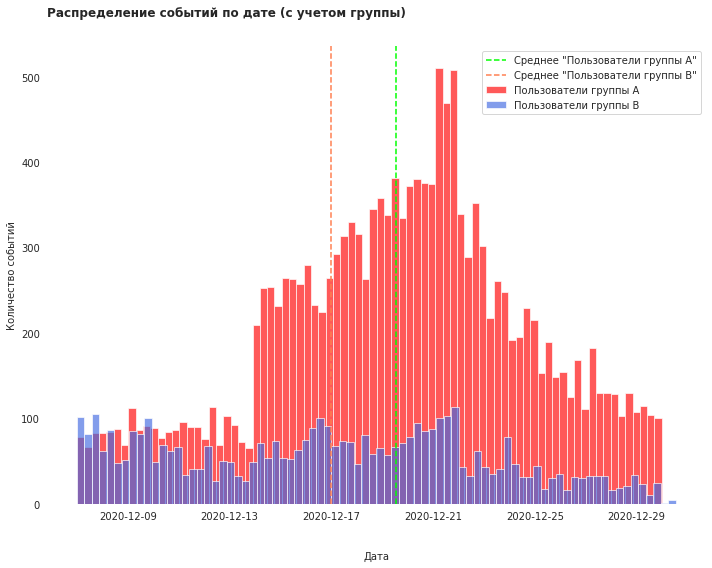

In [64]:
overlaid_histogram(group_a['event_dt'],
                   group_b['event_dt'],
                   labels, n_bins=80)

&#9889; **Выводы**

В середине декабря у группы А резкий рост и подъем по числу событий, затем, чем ближе к новому году, тем меньше активности. У группы В тоже есть подьемы и спады примерно в те же периоды, что и группы А, но менее выраженные, автивность также снижается ближе к новому году.

### - оценим полноту данных

Сгруппируем данные по дате и посчитаем количество наблюдений по каждому дню.

In [65]:
grouped_by_date = simple_grouper(events, 'dt')
grouped_by_date.drop('percent', axis=1)

,dt,user_id
14,2020-12-21,2048
13,2020-12-20,1571
12,2020-12-19,1497
11,2020-12-18,1309
10,2020-12-17,1276
15,2020-12-22,1272
9,2020-12-16,1192
7,2020-12-14,1107
8,2020-12-15,1102
16,2020-12-23,1004


&#9889; **Выводы**

Табличные данные подтверждают тенденцию к снижению активности: с каждым днем все меньше и меньше пользователей что-то делают в магазине.

[В оглавление](#TOC)

## 4) Воронка событий <a class="anchor" id="2_4"></a>

### - подготовим данные

Для воронки со всеми уникальными пользователями:

In [66]:
events_and_users = events.groupby('event_name', as_index=False).agg({'user_id': 'nunique'})

# Считаем общее число уникальных пользователей
events_and_users['total_users'] = events['user_id'].nunique()

# Считаем долю пользователей для каждого события
events_and_users['percent'] = round(events_and_users['user_id'] * 100 / 
                                    events_and_users['total_users'], 2)

# Переименовываем и сортируем результат
events_and_users.rename(columns={'user_id': 'unique_users'}, inplace=True)
events_and_users = events_and_users.set_index('event_name').reindex(['login', 'product_page',
                                                                     'product_cart', 'purchase']).reset_index()
events_and_users

,event_name,unique_users,total_users,percent
0,login,3050,3050,100.00
1,product_page,1905,3050,62.46
2,product_cart,900,3050,29.51
3,purchase,953,3050,31.25


Кроме того, нас интересуют как проходили воронку пользователи из разных групп. Соберем данные вместе:

In [67]:
events.groupby(['event_name', 'group']).agg({'user_id': 'nunique'}).reset_index()

,event_name,group,user_id
0,login,A,2279
1,login,B,771
2,product_cart,A,686
3,product_cart,B,214
4,product_page,A,1476
5,product_page,B,429
6,purchase,A,734
7,purchase,B,219


In [68]:
def events_order(row):
    if row['event_name'] == 'login':
        return 1
    if row['event_name'] == 'product_page':
        return 2
    if row['event_name'] == 'product_cart':
        return 3  
    if row['event_name'] == 'purchase':
        return 4      

In [69]:
# Сгруппируем логи по событиям и группам, посчитаем уникальных пользователей
groups = events.groupby(['event_name', 'group']).agg({'user_id': 'nunique'}).reset_index()

# Объединим две таблицы и выведем результат
groups = groups.merge(events_and_users)
groups['order'] = groups.apply(events_order, axis=1)
groups = groups.sort_values(by='order')

Получили таблицу где к каждому событию привязано число пользователей из каждой группы, учтена последовательность событий. 

In [70]:
groups

,event_name,group,user_id,unique_users,total_users,percent,order
0,login,A,2279,3050,3050,100.00,1
1,login,B,771,3050,3050,100.00,1
4,product_page,A,1476,1905,3050,62.46,2
5,product_page,B,429,1905,3050,62.46,2
2,product_cart,A,686,900,3050,29.51,3
3,product_cart,B,214,900,3050,29.51,3
6,purchase,A,734,953,3050,31.25,4
7,purchase,B,219,953,3050,31.25,4


[В оглавление](#TOC)

### - визуализируем продуктовую воронку

Подготовим функцию для визуализации

In [71]:
def funnel_plot(data, groups_labels=None,
                x='user_id', y='event_name',
                title='', *args, **kwargs):
    fig = go.Figure()
    
    # Если переданы маркеры групп
    if groups_labels:
        for group in groups_labels:
            sample = data.query(f'group == "{group}"')
            fig.add_trace(go.Funnel(
                name=group,
                y=sample[y],
                x=sample[x], *args, **kwargs))

    else: # Строим по всем данным
        fig.add_trace(go.Funnel(name='Все пользователи',
                                y=data[y],
                                x=data[x], *args, **kwargs))

    # Изменим размер, фон, добавим заголовок
    fig.update_layout(autosize=False,
                      width=700,
                      height=500,
                      paper_bgcolor='rgba(0,0,0,0)',
                      plot_bgcolor='rgba(0,0,0,0)',
                      title=title)
    fig.show()

Сначала по всем пользователям:

In [72]:
funnel_plot(data=events_and_users, 
            groups_labels=[], 
            title='Воронка событий по всем пользователям',
            x='unique_users')

Теперь примем во внимание группы пользователей:

In [73]:
funnel_plot(data=groups, 
            groups_labels=['A', 'B'], 
            title='Воронка событий по группам')

&#9889; **Выводы:**

1. С некоторой осторожностью, можно предположить, что конкурирующий тест интерфейса все таки проводился одновременно: возможно, внедрялась система оплаты минуя корзину.
2. Воронка для обеих групп по конверсии пользователей похожи.

[В оглавление](#TOC)

# III. Анализ A/B-теста<a class='anchor' id='3'></a>

## 1) Подготовимся к анализу<a class='anchor' id='3_1'></a>

Создадим класс для статистических тестов, подготовим несколько полезных функций:

In [74]:
class StatTest:
    """Класс для проведения статистических тестов и сборов результатов."""

    def __init__(self, data):
        self.data = data.copy()
        self.result = self.df_constructor()
        self.groups_total = (self.data.groupby('group')
                                      .agg({'user_id': 'nunique'})
                                      .reset_index())
        self.agg_groups = self.group_constructor()
        self.group_a = self.agg_groups.query('group == "A"')
        self.group_b = self.agg_groups.query('group == "B"')
        
    def df_constructor(self):
        df = pd.DataFrame(columns=['Выборка',
                                   'Нулевая гипотеза (Н0)',
                                   'Альтернативная гипотеза (Н1)',
                                   'alpha', 'p-value',
                                   'p-value < alpha',
                                   'Н0/Н1'])
        return df
    
    def group_constructor(self):
        """Собираем аггрегированные данные по группам."""
        
        # Зафикисируем порядок и исключим обучение
        order = self.data.drop_duplicates('event_name')[['event_name']]

        # Сгруппируем логи по событиям и группам, посчитаем уникальных пользователей
        groups = self.data.groupby(['event_name', 'group']).agg({'user_id': 'nunique'}).reset_index()

        for i in groups.group.unique():
            sum_of = int(self.groups_total.query(f'group == "{i}"')['user_id'])
            groups.loc[groups.group == f'{i}', 'total'] = sum_of

        return groups
        
    def event_picker(self, event):
        """Выбираем группы из данных."""
        
        group_a = self.group_a.query(f'event_name == "{event}"')
        group_b = self.group_b.query(f'event_name == "{event}"')

        return (group_a, group_b)

    def z_test(self, samples):
        """Проводим двухвыборочный Z-критерий."""

        group_a = samples[0]
        group_b = samples[1]

        # Фиксируем число попыток
        count = np.array([group_a['user_id'], group_b['user_id']])
        
        #  Пропорции от общего
        nobs = np.array([group_a['total'], group_b['total']])
            
        # Считаем статистику      
        _, p_value = proportions_ztest(count, nobs)
        return p_value[0]
    
    def test_designer(self, params):
        """Проводим статистические тесты, собираем результаты."""

        # Получаем данные для теста
        sample_name = params['sample_name']
        alpha = params['alpha']
        zero_hypothesis = params['zero_hypothesis']
        alt_hypothesis = params['alt_hypothesis']
        p_value = self.z_test(params['samples'])

        pvalue_alpha_comparsion = p_value < alpha
        hypo_check = 'Н1' if pvalue_alpha_comparsion else 'Н0'
        row = pd.Series([sample_name, zero_hypothesis,
                        alt_hypothesis, alpha, p_value,
                        pvalue_alpha_comparsion, hypo_check],
                        index=self.result.columns)

        self.result = self.result.append(row, ignore_index=True)

    def test_routine(self, sample_name):
        """Проводим множественные тесты."""
        for event in list(self.agg_groups.event_name.unique()):
            if event == 'login':
                continue
            # Делаем выборки
            groups_to_test = self.event_picker(event)
            params_of_test['samples'] = [*groups_to_test]
            # Передаем имя
            params_of_test['sample_name'] = f'{sample_name}: {event}'
            tests.test_designer(params_of_test)


def report_styler(report):
    """Выводим таблицу с заданным форматом."""
    display(report.style
                  .set_properties(**{'text-align': 'left'})
                  .set_table_styles([{'selector': 'th',
                                      'props': [('text-align', 'left')]}])
                  .format({'alpha': "{:.2f}", 'p-value < alpha': bool}))


Инициализируем класс:

In [75]:
tests = StatTest(events)

[В оглавление](#TOC)

## 2) Посчитаем метрики<a class='anchor' id='3_2'></a>

В соответствии с техническим заданием ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page,
- просмотры корзины — product_cart,
- покупки — purchase.


In [76]:
change = tests.agg_groups.copy()
change['%'] =  change['user_id'] / change['total'] 
change

,event_name,group,user_id,total,%
0,login,A,2279,2279.0,1.000000
1,login,B,771,771.0,1.000000
2,product_cart,A,686,2279.0,0.301009
3,product_cart,B,214,771.0,0.277562
4,product_page,A,1476,2279.0,0.647652
5,product_page,B,429,771.0,0.556420
6,purchase,A,734,2279.0,0.322071
7,purchase,B,219,771.0,0.284047


&#9889; **Выводы**

Улучшение в предполагаемые 10% не усматривается, усматривается ухудшение метрик:
- в шаг корзины снижение в группе В на 2 процентных пункта, относительное изменение -8%.
- в шаге товара - снижение в группе В на 9 процентых пунтков, относительное изменение -16%.
- в шаге покупки - снижение в группе В на 4 процентых пунтка, относительное изменение -14%.

[В оглавление](#TOC)

## 3) Проведем статистические тесты<a class="anchor" id="3_3"></a>

### - проведем статистические тесты в отношении группы А и В

Проверим гипотезу о том, что доли пользователей в группе А и группе В одинаковы на каждом из шагов. Примем Z-тест для проверки гипотезы о равенстве долей в группах.

1. Нулевую гипотезу, которую проверяет тест, сформулируем так: "Между долями пользователей в группах нет статистически значимой разницы",
2. Альтернативную гипотезу, соответственно, сформулируем так: "Между долями пользователей в группах есть статистически значимая разница",
3. Примем уровень значимости в 5% с поправкой Бонферрони - разделим alpha на число проверяемых гипотез - 3.

Подготовим параметры для теста:

In [77]:
sample_name = 'A и В'
params_of_test = {'sample_name': sample_name,
                  'alpha': 0.05 / 3,
                  'zero_hypothesis': 'Между долями пользователей нет различий',
                  'alt_hypothesis': 'Между долями пользователей есть различия',
                  'test': 'z_test'}

Проведем тест и выведем результат:

In [78]:
tests.test_routine(sample_name=sample_name)

Выведем результат:

In [79]:
report_styler(tests.result)

,Выборка,Нулевая гипотеза (Н0),Альтернативная гипотеза (Н1),alpha,p-value,p-value < alpha,Н0/Н1
0,A и В: product_cart,Между долями пользователей нет различий,Между долями пользователей есть различия,0.02,0.217211,False,Н0
1,A и В: product_page,Между долями пользователей нет различий,Между долями пользователей есть различия,0.02,0.000006,True,Н1
2,A и В: purchase,Между долями пользователей нет различий,Между долями пользователей есть различия,0.02,0.048943,False,Н0


&#9889; **Выводы**


1. В отношении различий долей между группами А и В на шаг product_cart, исходя из представленных данных, на уровне значимости 5% - нет основания отвергнуть нулевую гипотезу в пользу альтернативы: между долями пользователей групп А и В нет статистически значимых различий.
2. В отношении различий долей между группами А и В на шаг product_page, исходя из представленных данных, на уровне значимости 5% - есть основания отвергнуть нулевую гипотезу в пользу альтернативы: между долями пользователей групп А и В есть статистически значимые различия.
3. В отношении различий долей между группами А и В на шаг purchase, исходя из представленных данных, на уровне значимости 5% - нет основания отвергнуть нулевую гипотезу в пользу альтернативы: между долями пользователей групп А и В нет статистически значимых различий.

[В оглавление](#TOC)

# Выводы<a class='anchor' id='conclusions'></a>

1. В представленных данных о событиях 440 317 наблюдений о 58703 уникальных пользователей за период от 07.12.2020 до 30.12.2020 года. 
2. Исходя из представленных данных, 18 268 из 58 703 (31%) уникальных пользователей принимало участие в А/В-тестировании: рекомендательной системы и нового интерфейса. 
3. Представленные данные не соответствуют техническому заданию и правилам проведения А/В-тестирования:
    - предполагаемая дата остановки теста — 04.01.2021 года, однако данные представлены до 30.12.2020 года,
    - аудитория теста — новые пользователи из Европы, однако в аудиторию теста попали 350 человек из других регионов,
    - из 18 268 участников 1602 участника приняло участие в двух тестах (с высокой степенью вероятности, проводившегося одновременно),
    - предполагаемая дата остановки набора новых пользователей — 21.12.2020 года не соответствует  ожидаемому периоду улучшения метрик — 14 дням,
    - в период проведения тестирования проходила маркетинговая акция — Рождественское и Новогоднее промо, чего лучше избегать, чтобы не получить смешенные результаты.
    - для проведения теста с рекомендательной системы выбран неоптимальный предновогодний период — поведение пользователей в целом смещено относительно обычного среднего поведения, характерен повышенный спрос почти на все виды товаров.
    - после очистки данных — осталось 3050 пользователей из изначальных 6701 (45%), что не соответствует ожидаемому 6000 участников.
4. Вместо ожидаемого улучшения метрик в 10%, усматривается ухудшение метрик, причем на шаге product_page, на уровне значимости 5%, есть статистически значимая разница между долями пользователей.
5. Представляется, что нет возможности продолжить тест, поскольку, во-первых, данные о тесте уже были проанализированы, рекомендовано остановить тест, признать его неуспешным, перейти к проверке следующей гипотезы.

[В оглавление](#TOC)